# **Segmentation des données clients d'un site e-commerce**

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
src = list(files.upload().values())[0]
open('functions.py','wb').write(src)
import functions

Saving functions.py to functions.py


## I Segmentation RFM

**1- Chargement des données**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn import metrics
from sklearn.metrics import silhouette_samples,silhouette_score, davies_bouldin_score, adjusted_rand_score
from geopy.distance import geodesic
from sklearn.cluster import SpectralBiclustering
import matplotlib.cm as cm

In [ ]:
from yellowbrick.style import set_palette
set_palette('flatui')


In [ ]:
def haversine_vectorize(lon1, lat1, lon2, lat2):
    """Calculate distance between two points with Haversine methods
    source : https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/"""

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [ ]:
path1 = "/content/gdrive/My Drive/P4/db_inter_avant_RFM.csv"
path2 = "/content/gdrive/My Drive/P4/RFM.csv"
df=pd.read_csv(path1)
RFM=pd.read_csv(path2)


In [ ]:
df.head(5)

,product_category_name_english,customer_id,order_id,customer_city,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,price,payment_value,year,month,day,review_score,customer_latitude,customer_longitude,seller_latitude,seller_longitude
0,perfumery,f8a3e963a310aa58b60a5b1fed5bceb5,e17e4f88e31525f7deef66779844ddce,mogi-guacu,2018-04-24 16:16:53,2018-04-24 19:04:19,2018-04-25 17:01:00,2018-04-27 16:42:17,2018-05-09 00:00:00,b1a1199364a4a7fe27c4486ab63f550d,10.91,18.30,2018,4,24,5,-22.342774,-46.927142,-23.537922,-46.477696
1,baby,322162b5ca010c2b059cb5224dd818b1,143d00a4f2dde4e0364ee1821577adb3,sao paulo,2018-08-03 08:55:50,2018-08-03 09:31:42,2018-08-03 11:48:00,2018-08-06 15:14:32,2018-08-08 00:00:00,619e926d09b26efbd5180368b1ddc874,112.30,121.84,2018,8,3,1,-23.493511,-46.631067,-23.089035,-47.214419
2,bed_bath_table,d436890d44092b00fcfcbdd7a168c240,a4425e2bccba621150a07a685cf063be,sao paulo,2018-06-26 14:27:52,2018-06-26 14:57:15,2018-06-27 11:31:00,2018-06-29 16:18:52,2018-07-18 00:00:00,ed42ccde391485cde5b0699b84b5c070,41.99,111.72,2018,6,26,5,-23.599568,-46.666486,-21.766477,-48.831547
3,bed_bath_table,d436890d44092b00fcfcbdd7a168c240,a4425e2bccba621150a07a685cf063be,sao paulo,2018-06-26 14:27:52,2018-06-26 14:57:15,2018-06-27 11:31:00,2018-06-29 16:18:52,2018-07-18 00:00:00,ed42ccde391485cde5b0699b84b5c070,41.99,111.72,2018,6,26,5,-23.599568,-46.666486,-21.766477,-48.831547
4,furniture_decor,ac8d05674efe12528f6d96c507aac3bc,0a4581df52d24b72b87ae0feb1b11d08,florianopolis,2018-05-11 13:28:31,2018-05-11 13:50:45,2018-05-15 16:11:00,2018-05-21 16:52:07,2018-05-30 00:00:00,4148cb4b02695af300af0674b9b3a723,79.90,98.04,2018,5,11,5,-27.615683,-48.587666,-25.472735,-49.305638


In [ ]:
RFM.head(5)

,customer_id,Recency,Frequency,MonetaryValue
0,001051abfcfdbed9f87b4266213a5df1,92,3,65.20
1,0013cd8e350a7cc76873441e431dd5ee,114,1,92.60
2,0015bc9fd2d5395446143e8b215d7c75,79,1,132.19
3,0018c09f333634ca9c80d9ff46e43e9c,59,1,56.87
4,001df1ee5c36767aa607001ab1a13a06,24,1,42.86


**1-Ajout de variables supplémentaires**

On va créer de nouvelles variables que l'on va ajouter pour pouvoir obtenir une segmentation plus fine. Parmi ces variables, on va ajouter le nombre de jours entre la commande (order_approved_at) et la réception de cette dernière, la distance entre le client et le vendeur, l'avis du client et la catégorie de produits commandée.

In [ ]:
# Transformation timestamps into datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

In [ ]:
df["nb_days_before_delivered"] = df["order_delivered_customer_date"] \
                                        - df["order_approved_at"]
df["nb_days_before_delivered_estimation"] = df["order_estimated_delivery_date"] \
                                                   - df["order_approved_at"]

cols_var = ["nb_days_before_delivered",
            "nb_days_before_delivered_estimation"]

for cols in cols_var:
    df[cols] = df[cols].dt.days



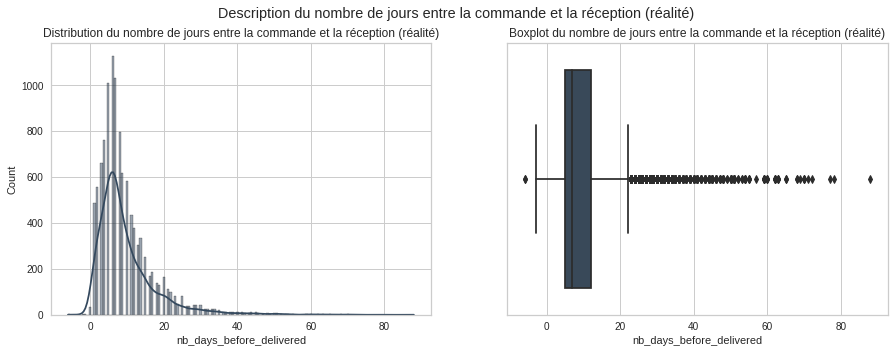

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Description du nombre de jours entre la commande et la réception (réalité)')

sns.histplot(ax=axes[0], x="nb_days_before_delivered", data=df, kde=True)
axes[0].set_title("Distribution du nombre de jours entre la commande et la réception (réalité)")

sns.boxplot(ax=axes[1], x="nb_days_before_delivered", data=df)
axes[1].set_title("Boxplot du nombre de jours entre la commande et la réception (réalité)")

plt.show()

In [ ]:
df["distance_customer_seller"] = haversine_vectorize(
    df["customer_longitude"],
    df["customer_latitude"],
    df["seller_longitude"],
    df["seller_latitude"])

In [ ]:
df = df.loc[df["nb_days_before_delivered"] > 0]
df= df.loc[df["nb_days_before_delivered_estimation"] > 0]
df= df.loc[df["distance_customer_seller"] > 0]

In [ ]:
df["product_category_name"]=df['product_category_name_english']
df1=df[["customer_id","customer_city", "product_category_name",'nb_days_before_delivered', 'nb_days_before_delivered_estimation','review_score', 'distance_customer_seller','customer_latitude','customer_longitude']]

In [ ]:
data = pd.merge(RFM, df1,
                on="customer_id",
                how="left")
data.head(5)

,customer_id,Recency,Frequency,MonetaryValue,customer_city,product_category_name,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,distance_customer_seller,customer_latitude,customer_longitude
0,001051abfcfdbed9f87b4266213a5df1,92,3,65.20,sao paulo,housewares,5.0,34.0,4.0,469.275714,-23.479895,-46.595511
1,001051abfcfdbed9f87b4266213a5df1,92,3,65.20,sao paulo,housewares,5.0,34.0,4.0,469.275714,-23.479895,-46.595511
2,001051abfcfdbed9f87b4266213a5df1,92,3,65.20,sao paulo,housewares,5.0,34.0,4.0,469.275714,-23.479895,-46.595511
3,0013cd8e350a7cc76873441e431dd5ee,114,1,92.60,sao paulo,furniture_decor,3.0,16.0,5.0,354.354281,-23.571105,-46.491891
4,0015bc9fd2d5395446143e8b215d7c75,79,1,132.19,sao jose dos campos,fixed_telephony,2.0,14.0,5.0,84.960859,-23.237250,-45.880830


In [ ]:
data=data.dropna(axis=0)

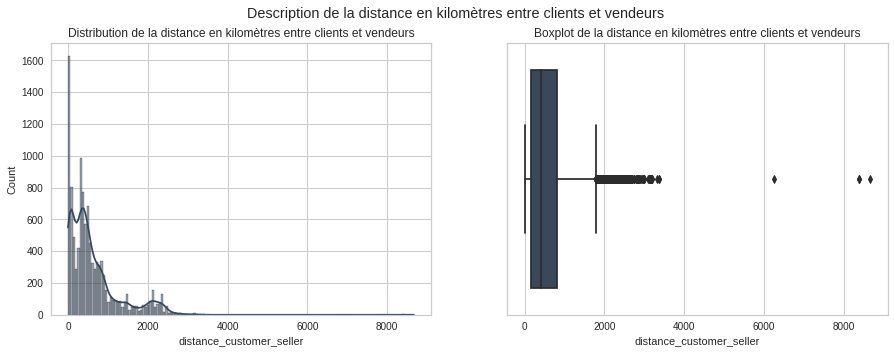

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description de la distance en kilomètres entre clients et vendeurs')

sns.histplot(ax=axes[0], x="distance_customer_seller", data=data, kde=True)
axes[0].set_title("Distribution de la distance en kilomètres entre clients et vendeurs")

sns.boxplot(ax=axes[1], x="distance_customer_seller", data=data)
axes[1].set_title("Boxplot de la distance en kilomètres entre clients et vendeurs")

plt.show()

In [ ]:
data1=data.to_csv('data_RFM.csv',index=False)

## II- Modèlisation

**1 Préparation des données**

In [ ]:
X =data[['Recency', 'Frequency', 'MonetaryValue','nb_days_before_delivered','review_score','distance_customer_seller']].copy()
# Conversion types
X["review_score"] = X["review_score"].astype("int32")


In [ ]:
# transformation distance en log
for col in X.columns:
  X[col] = np.log1p(X[col])

In [ ]:
X

,Recency,Frequency,MonetaryValue,nb_days_before_delivered,review_score,distance_customer_seller
0,4.532599,1.386294,4.192680,1.791759,1.609438,6.153319
1,4.532599,1.386294,4.192680,1.791759,1.609438,6.153319
2,4.532599,1.386294,4.192680,1.791759,1.609438,6.153319
3,4.744932,0.693147,4.539030,1.386294,1.791759,5.873115
4,4.382027,0.693147,4.891777,1.098612,1.791759,4.453892
...,...,...,...,...,...,...
11097,4.343805,0.693147,4.944567,0.693147,1.791759,4.202095
11098,4.248495,0.693147,4.615615,2.639057,1.791759,7.565123
11099,2.833213,0.693147,4.196299,2.079442,1.609438,5.817369
11100,4.709530,0.693147,5.035458,1.945910,0.693147,3.654384


* **Normalisation**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
customers_normalized = scaler.transform(X)
df_normalized = pd.DataFrame(customers_normalized, columns=["Recency","Frequency","MonetaryValue",'nb_days_before_delivered','review_score','distance_customer_seller'])

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [0. 0. 0. 0. 0. 0.]
Standard Deviation: [1. 1. 1. 1. 1. 1.]


In [ ]:
df_normalized1=df_normalized.to_csv('df_normalized.csv',index=False)

**2- Dimensionality reduction with PCA**

La réduction de dimension a pour but de faciliter la visualisation de nos données en les ramenant dans un espace en 2 dimensions (ou en 3 dimensions). De plus, la réduction de dimensions permet de diminuer le temps de calcul des algorithmes de clustering.

In [ ]:
from sklearn.decomposition import PCA
#PCA with two principal components
n_comp=6
pca=PCA(n_components=n_comp)
PCA_2d = pca.fit(customers_normalized)
#PCA_2d.head()
print(PCA_2d.explained_variance_)
PCA_2d = pca.fit_transform(customers_normalized )
pcs = pca.components_

[1.89984682 1.52373576 0.93875831 0.89508208 0.39782484 0.34529498]


In [ ]:
# On determine le nombre de compasantes pour faire l'acp
np.argmax(np.cumsum(pca.explained_variance_ratio_)>0.95)

5

In [ ]:
from sklearn.decomposition import PCA
#PCA with two principal components
n_comp=5
pca=PCA(n_components=n_comp)
PCA_2d = pca.fit(customers_normalized)
#PCA_2d.head()
print(PCA_2d.explained_variance_)
PCA_2d = pca.fit_transform(customers_normalized )
pcs = pca.components_

[1.89984682 1.52373576 0.93875831 0.89508208 0.39782484]


<Figure size 2160x720 with 0 Axes>

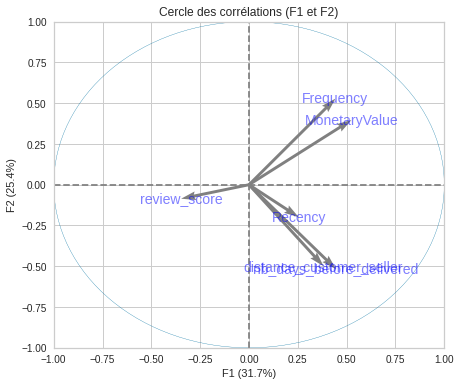

In [ ]:
from functions import *
features = df_normalized.columns
plt.figure(figsize=(30,10))
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

**1-Kmeans**

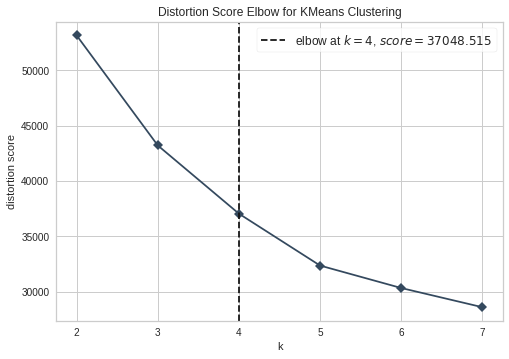

In [ ]:
# Elbow pour choisir le nombre classe
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 8), timings=False)
visualizer.fit(customers_normalized)        
visualizer.show() 

Selon la méthode du coude, le nombre de cluster idéal est de **4**. On va donc entraîner notre modèle avec ce paramètre.

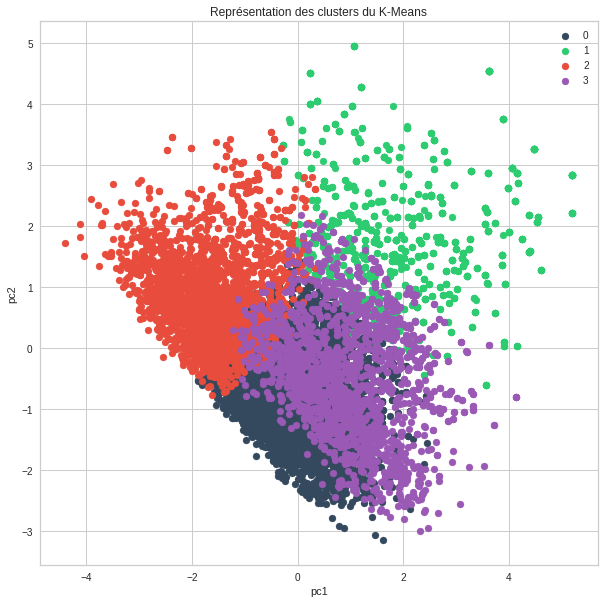

In [ ]:
# Fitting KMeans
km = KMeans(n_clusters=4, random_state=42)

# Prediction
label = km.fit_predict(customers_normalized)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(PCA_2d[label==i, 0], PCA_2d[label==i, 1], label = i)
plt.legend()
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:
# VIsualisation des clusters sur les 3 premiers plans factoriels
import plotly.graph_objs as go
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = km.labels_
trace = go.Scatter3d(x=PCA_2d[:,0], y=PCA_2d[:,1], z=PCA_2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

**1-1 Description des clusters obtenus avec le modèle**

In [ ]:
rfm=X[['Recency','Frequency','MonetaryValue','nb_days_before_delivered','review_score','distance_customer_seller']]
rfm["Cluster"] = km.labels_
data_clusters_analysis = rfm.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean",'nb_days_before_delivered': "mean",'review_score': "mean",'distance_customer_seller':'mean'}).round(2)
data_clusters_analysis.reset_index()

,Cluster,Recency,Frequency,MonetaryValue,nb_days_before_delivered,review_score,distance_customer_seller
0,0,4.16,0.76,4.92,2.34,1.72,6.43
1,1,4.22,1.65,7.05,2.12,1.33,5.73
2,2,3.83,0.79,4.56,1.42,1.62,3.83
3,3,4.21,0.85,5.21,2.56,0.77,6.19


In [ ]:
rfm['ID'] = rfm.index
rfm["Cluster"] = km.labels_
df_nor_melt = pd.melt(rfm.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue",'nb_days_before_delivered','review_score','distance_customer_seller'],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,0,Recency,4.532599
1,1,0,Recency,4.532599
2,2,0,Recency,4.532599
3,3,0,Recency,4.744932
4,4,2,Recency,4.382027


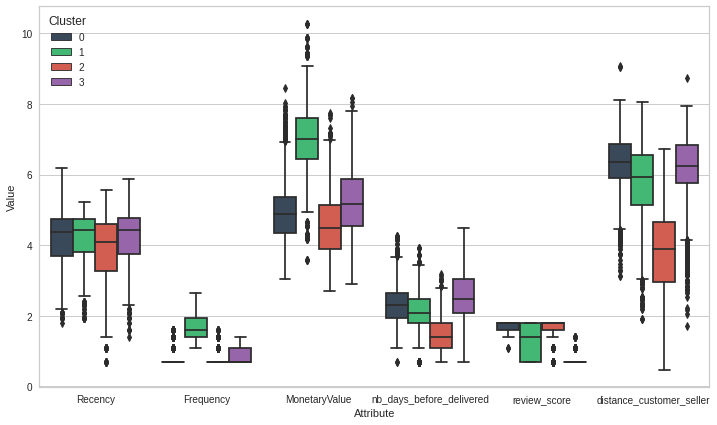

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(y='Value',x='Attribute',hue='Cluster',data=df_nor_melt)

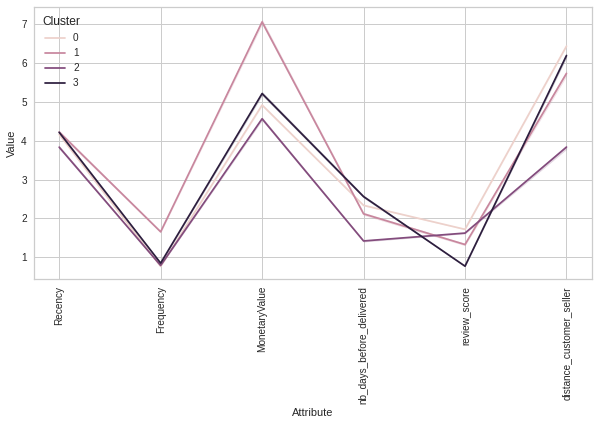

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.title('Comparaison des moyennes en log1p des variables par cluster')
plt.show()

*  **Descriptions des clients**

D'après l'analyse des moyennes associées à chaque cluters on peut distinguer 4 types de clients:

- Le client moyen : Il a acheté plus de 2 fois et dépense une somme moyenne. Les avis laissés par ce client sont plutôt positifs. Il commande auprès de vendeurs qui se trouvent à une distance moyenne de lui. Les délais de livraison sont moyens (5 jours).
- Le client mécontent : Il a commandé plus de 2 fois et dépense des sommes très importantes (1097.63 réaux). Les avis laissés par ce type de client sont les bons (note 2). Il commande des produits qui se trouvent à une grande distance avec un délai de livraison importante (13 jours).
- Le Client actif : Il a commandé plus de 6 fois. C'est aussi celui qui a la moyenne d'achat la plus grande (1340.44 réaux). Il habite à une distance importante de son vendeur et le délai de livraison est moyen (environ 9 jours).Les avis laissés par ce type de client sont parmi les plus bons(4.7).

- Le client satisfait : Il a commandé plus de 2 fois. Il se distingue des autres par ses avis plus élevés que la moyenne(5) et un delai de livraison moyen (10 jours). Il commande au près des vendeurs un peu éloigné.

**1-2 Evaluation du modéle**

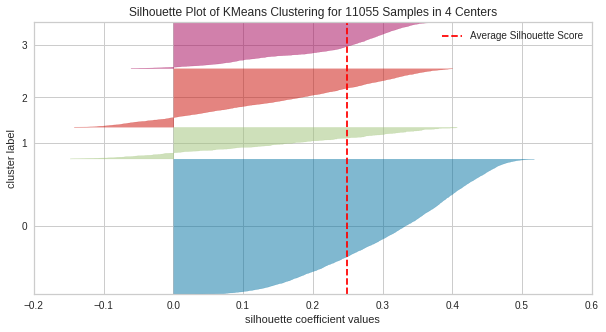

In [ ]:
plt.figure(figsize=(10,5))
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(customers_normalized)
visualizer.show()

In [ ]:
Result=pd.DataFrame()

In [ ]:
print("Silhouette Score:", silhouette_score(customers_normalized, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(customers_normalized, label))

Silhouette Score: 0.248552552541764
Score de Davies-Bouldin: 1.389337155915072


In [ ]:
Result=Result.append(pd.DataFrame({'Model':['kmeans'],'silhouette_score':[silhouette_score(customers_normalized, label)],'davies_bouldin_score':[davies_bouldin_score(customers_normalized, label)]}),ignore_index=True)

In [ ]:
from sklearn import metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(km.labels_, label))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(km.labels_, label))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(km.labels_, label))


Homogeneity: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


**2-Dendograme**

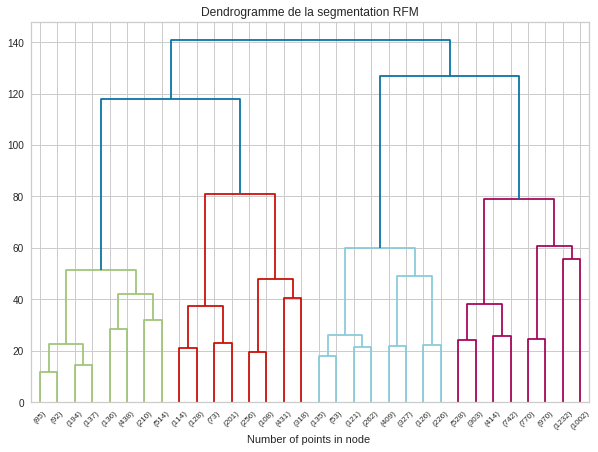

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(customers_normalized)

# plot the top three levels of the dendrogram
plt.figure(figsize=(10,7)) 
plt.title('Dendrogramme de la segmentation RFM')
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node ")
plt.show()

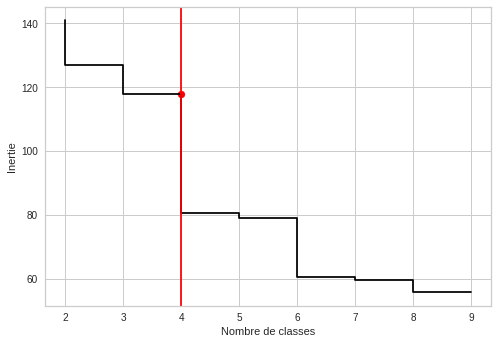

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Z = linkage(customers_normalized,method='ward',

      metric='euclidean')

last = Z[-8:, 2]

last_rev = last[::-1]

idxs = np.arange(2, len(last) + 2)

plt.step(idxs, last_rev, c="black")

plt.xlabel("Nombre de classes")

plt.ylabel("Inertie")

nombre = 4 # Ici, on teste le scénario où il y aurait 3 catégories

plt.scatter(idxs[np.where(idxs==nombre)], last_rev[np.where(idxs==nombre)], c="red")

plt.axvline(idxs[np.where(idxs==nombre)], c="red")

plt.show()

On voit sur ce graphique 2 grands sauts d'inertie pour 2 et 4 classes. Cela suggère bien qu'une découpe en 2 ou 4 serait pertinente, mais pas au delà. D'où le choix des 4 classes.

In [ ]:
import plotly.graph_objs as go
dend= AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
dend.fit(customers_normalized)
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = dend.labels_
trace = go.Scatter3d(x=PCA_2d[:,0], y=PCA_2d[:,1], z=PCA_2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

**2-1 Descrition des clusters**

In [ ]:

#cluster_labels = dend.fit_predict(customers_normalized)
rfm=X[["Recency", "Frequency", "MonetaryValue",'nb_days_before_delivered',	'review_score','distance_customer_seller']]
rfm["Cluster"] = dend.labels_
data_clusters_analysis = rfm.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)
data_clusters_analysis

,Recency,Frequency,MonetaryValue
Cluster,,,
0,4.01,1.48,6.62
1,4.19,0.77,4.88
2,3.79,0.73,4.45
3,4.19,0.89,5.30


In [ ]:
rfm['ID'] = rfm.index
rfm["Cluster"] =dend.labels_
df_nor_melt = pd.melt(rfm.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue",'nb_days_before_delivered',	'review_score','distance_customer_seller'],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,1,Recency,4.532599
1,1,1,Recency,4.532599
2,2,1,Recency,4.532599
3,3,1,Recency,4.744932
4,4,2,Recency,4.382027


Text(0.5, 1.0, 'Distribution des clusters')

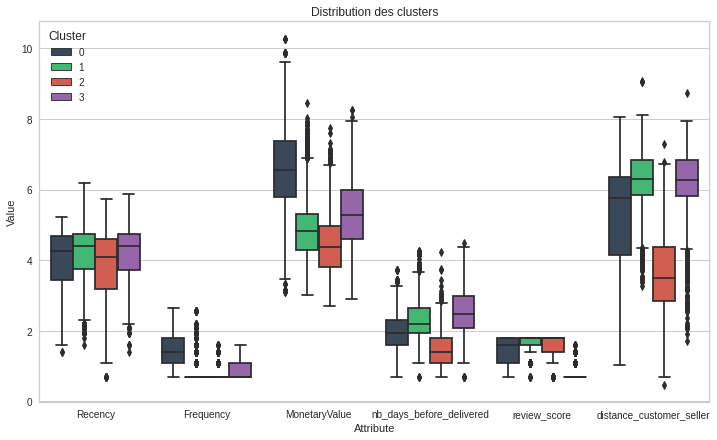

In [ ]:
plt.figure(figsize=(12,7))
sns.boxplot(y='Value',x='Attribute',hue='Cluster',data=df_nor_melt)
plt.title('Distribution des clusters')

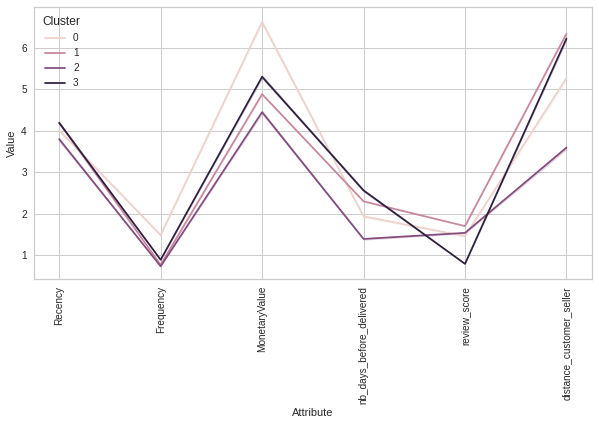

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.title('Comparaison des moyennes en log1p des variables par cluster')
plt.show()

L'analyse des moyennes associées à chaque cluters montre 4 types de clients:

- **Le client moyen**, **actif**, **satisfait** et **mécontent**.

**2-2 Evaluation du modèle**

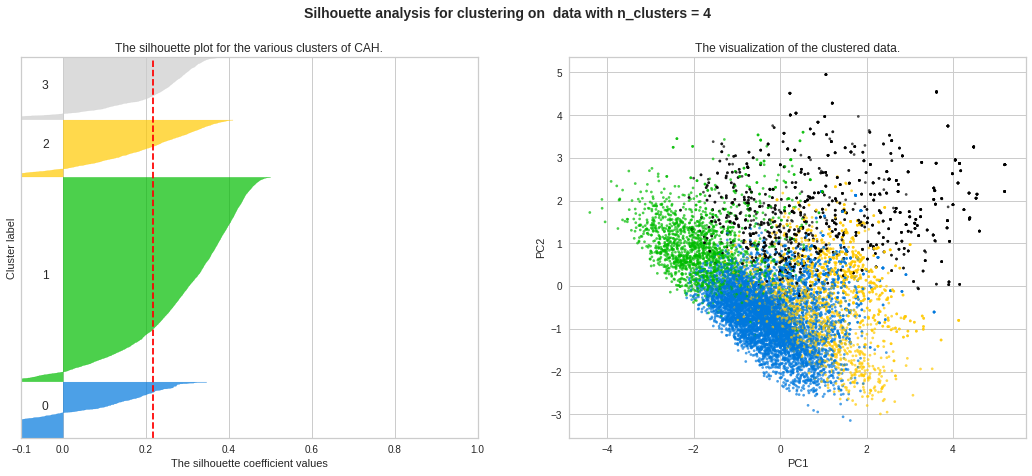

In [ ]:
n_clusters=4
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(customers_normalized) + (n_clusters) * 10])
# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster_labels = clusterer.fit_predict(customers_normalized)
silhouette_avg = silhouette_score(customers_normalized, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(customers_normalized, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(customers_normalized, cluster_labels)

y_lower = 10
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i+1) / n_clusters)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters of CAH.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral((cluster_labels.astype(float)) / n_clusters)
ax2.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.suptitle(("Silhouette analysis for clustering on  data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
print("Silhouette Score:", silhouette_score(customers_normalized, cluster_labels))
print("Score de Davies-Bouldin:", davies_bouldin_score(customers_normalized, cluster_labels))

Silhouette Score: 0.2163827796007091
Score de Davies-Bouldin: 1.4867462931834883


In [ ]:
Result=Result.append(pd.DataFrame({'Model':['CAH'],'silhouette_score':[silhouette_score(customers_normalized, cluster_labels)],'davies_bouldin_score':[davies_bouldin_score(customers_normalized, cluster_labels)]}),ignore_index=True)

In [ ]:

print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(dend.labels_, cluster_labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(dend.labels_, cluster_labels))


Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


**3-DBSCAN**

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

In [ ]:

db = DBSCAN(eps=1, min_samples=120,metric='euclidean').fit(customers_normalized)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = np.abs(db.labels_)
labels_true = np.abs(db.fit_predict(customers_normalized))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


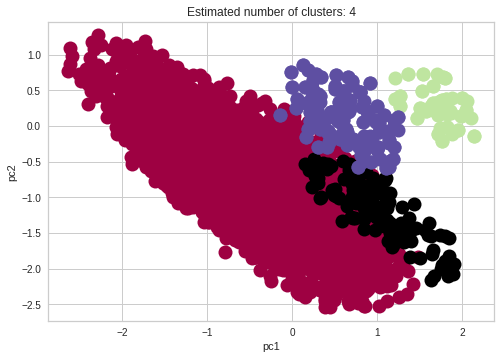

In [ ]:
import matplotlib.pyplot as plt
# Black removed and is used for noise instead.
unique_labels = set(np.abs(labels))
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == 1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = PCA_2d[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
# VIsualisation des clusters sur les 3 premiers plans factoriels
import plotly.graph_objs as go
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = labels
trace = go.Scatter3d(x=PCA_2d[:,0], y=PCA_2d[:,1], z=PCA_2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

**3-1 Description des cluster**

In [ ]:
rfm=X[["Recency", "Frequency", "MonetaryValue",'nb_days_before_delivered',	'review_score','distance_customer_seller']]
rfm["Cluster"] = np.abs(labels)
data_clusters_analysis = rfm.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': "mean"}).round(2)
data_clusters_analysis

,Recency,Frequency,MonetaryValue
Cluster,,,
0,4.13,0.69,4.69
1,3.97,1.12,5.66
2,4.56,1.13,5.89
3,4.39,1.12,5.69


In [ ]:
rfm['ID'] = rfm.index
rfm["Cluster"] = np.abs(labels)

df_nor_melt = pd.melt(rfm.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars=["Recency", "Frequency", "MonetaryValue",'nb_days_before_delivered',	'review_score','distance_customer_seller'],
                      var_name="Attribute",
                      value_name="Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,1,Recency,4.532599
1,1,1,Recency,4.532599
2,2,1,Recency,4.532599
3,3,0,Recency,4.744932
4,4,0,Recency,4.382027


Text(0.5, 1.0, 'Distribution des clusters')

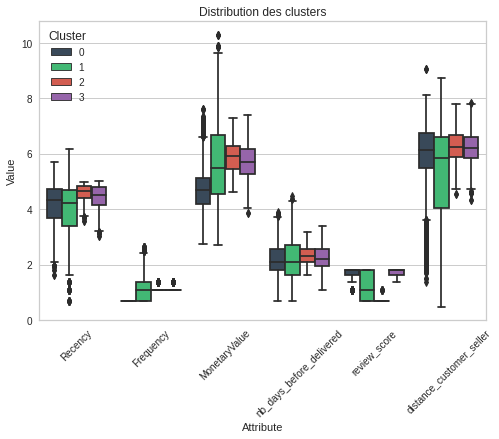

In [ ]:
sns.boxplot(y='Value',x='Attribute',hue='Cluster',data=df_nor_melt)
plt.xticks(rotation=45)
plt.title('Distribution des clusters')

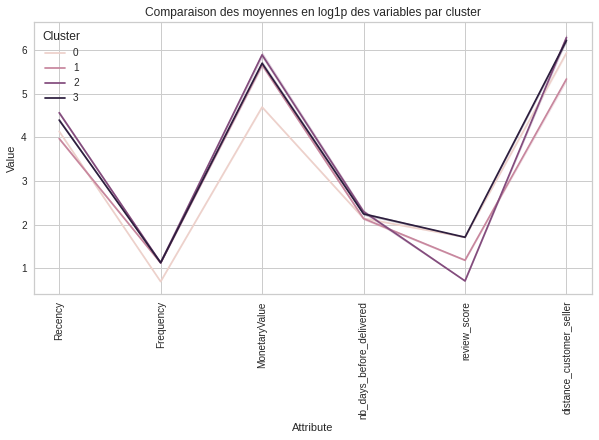

In [ ]:
plt.figure(figsize=(10,5))
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.xticks(rotation=90)
plt.title('Comparaison des moyennes en log1p des variables par cluster')
plt.show()

L'analyse des moyennes associées à chaque cluters montre 4 types de clients:

- **Le client moyen**, **actif**, **satisfait** et **mécontent**.

**3-2 Evaluation du modèle**

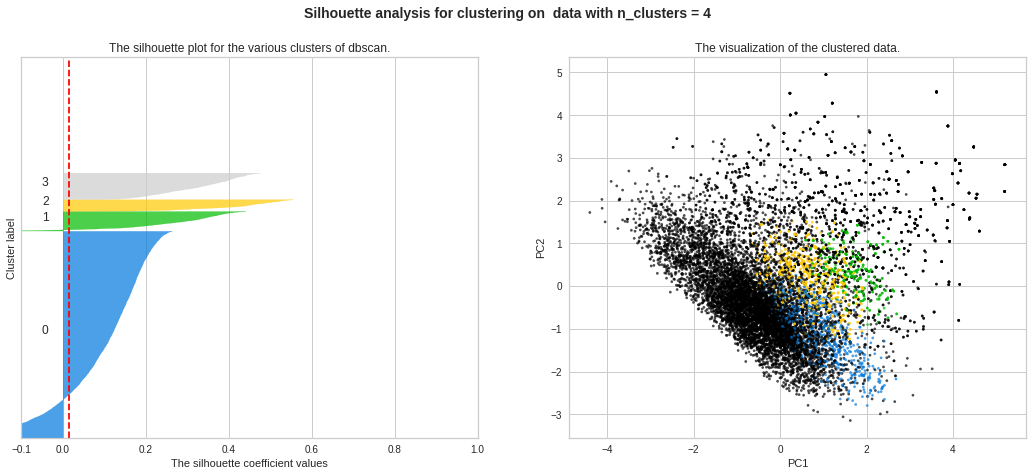

In [ ]:
n_clusters=4
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(PCA_2d) + (n_clusters) * 10])
# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
cluster_labels = db.labels_
silhouette_avg = silhouette_score(customers_normalized, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(customers_normalized, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(customers_normalized, cluster_labels)
y_lower = 10
for i in range(n_clusters):
  # Aggregate the silhouette scores for samples belonging to
  # cluster i, and sort them
  ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

  ith_cluster_silhouette_values.sort()

  size_cluster_i = ith_cluster_silhouette_values.shape[0]
  y_upper = y_lower + size_cluster_i

  color = cm.nipy_spectral(float(i+1) / n_clusters)
  ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
  # Label the silhouette plots with their cluster numbers at the middle
  ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

  # Compute the new y_lower for next plot
  y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters of dbscan.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral((cluster_labels.astype(float)) / n_clusters)
ax2.scatter(PCA_2d[:, 0], PCA_2d[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

   

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.suptitle(("Silhouette analysis for clustering on  data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
from sklearn.metrics import pairwise_distances
print("Silhouette Score:", silhouette_score(customers_normalized, labels_true))
print("Score de Davies-Bouldin:", davies_bouldin_score(customers_normalized, labels_true))

Silhouette Score: -0.007434393660548909
Score de Davies-Bouldin: 2.5111098583954505


In [ ]:
Result=Result.append(pd.DataFrame({'Model':['dbscan'],'silhouette_score':[silhouette_score(customers_normalized, labels_true)],'davies_bouldin_score':[davies_bouldin_score(customers_normalized, labels_true)]}),ignore_index=True)

In [ ]:

print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels,labels_true))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels, labels_true)
)


Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


## Conclusion

In [ ]:
Result

,Model,silhouette_score,davies_bouldin_score
0,kmeans,0.248553,1.389337
1,CAH,0.216383,1.486746
2,dbscan,-0.007434,2.511110


Le modèle Kmeans possède les meilleurs scores. Donc, le Kmeans semble mieux fonctionner que les autres méthodes de clustering et nous essayons utiliser cet algorithme à l'ensemble du jeu de données pour partitioner nos différents types clients et regarder par la suite le delais de maintenance et voir aussi le flux de clients pendant la durée stable des segments.